In [47]:
import pandas as pd 
import math
import geopandas as gpd
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib as plt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import interpolate
%matplotlib inline
from sklearn.cluster import KMeans


spreadsheet = pd.read_csv('/Users/bayardwalsh/Downloads/Boston_Crime_Data.csv', low_memory=False)


In [24]:
spreadsheet.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182061268,3201,Property Lost,PROPERTY - LOST,NaN,,NaN,6/15/2015 0:00,2015,6,Monday,0,Part Three,BERNARD,-1.000000,-1.000000,"(-1.00000000, -1.00000000)"
1,I172040657,2629,Harassment,HARASSMENT,C11,397,NaN,6/15/2015 0:00,2015,6,Monday,0,Part Two,MELBOURNE ST,42.291093,-71.065945,"(42.29109287, -71.06594539)"
2,I162013546,3201,Property Lost,PROPERTY - LOST,B3,433,NaN,6/15/2015 0:00,2015,6,Monday,0,Part Three,NORFOLK ST,42.283634,-71.082813,"(42.28363434, -71.08281320)"
3,I152067251,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,A1,93,NaN,6/15/2015 0:00,2015,6,Monday,0,Part Two,FANEUIL HALL SQ,42.360205,-71.056208,"(42.36020464, -71.05620816)"
4,I152059178,2647,Other,THREATS TO DO BODILY HARM,C11,359,NaN,6/15/2015 0:00,2015,6,Monday,0,Part Two,WASHINGTON ST,42.293606,-71.071887,"(42.29360585, -71.07188650)"


In [4]:
# Dataframe with crimes listed by count
crimes_by_count = pd.DataFrame({'Count': spreadsheet.OFFENSE_CODE_GROUP.value_counts().sort_values(ascending = False)})
crimes_by_count['Index']=[i for i in range(1,crimes_by_count.size+1)]
crimes_by_count


,Count,Index
OFFENSE_CODE_GROUP,,
Motor Vehicle Accident Response,49603,1
Larceny,34750,2
Medical Assistance,32741,3
Investigate Person,24754,4
Other,24050,5
...,...,...
HUMAN TRAFFICKING,8,63
INVESTIGATE PERSON,5,64
Burglary - No Property Taken,5,65


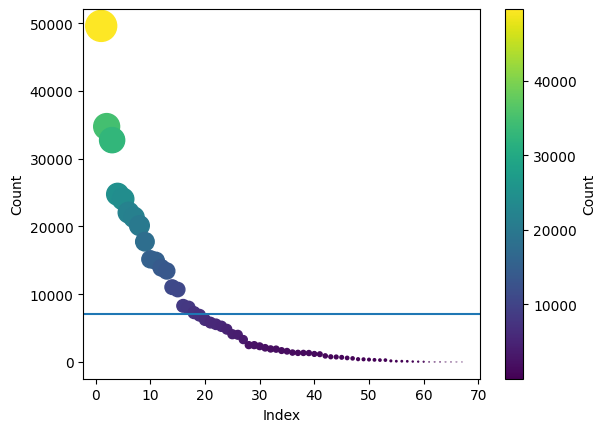

In [5]:
# some bug here
# Scatterplot with crime amount indicating size, distributed by index
graph = crimes_by_count.plot.scatter(x='Index', y='Count',s=crimes_by_count["Count"] * .01, c='Count',cmap="viridis")
median= math.floor(len(spreadsheet)/len(crimes_by_count)) #Average line
graph.axhline(y=median)

In [6]:
#Heat map with sample size 10,000 crimes 
location_of_crimes = spreadsheet[spreadsheet.OFFENSE_CODE_GROUP.isin(crimes_by_count.index)].loc[:, ['Lat', 'Long']].dropna()

m=folium.Map(location = [42.320,-71.05], 
                  zoom_start = 11,
                  min_zoom = 11
)

HeatMap(data=location_of_crimes.sample(10000), radius=16).add_to(m)

m

In [7]:
#List crimes with Greater than 10,000 recorded cases, or 'most common crimes', which is 15 total offense code
most_common_crimes = pd.DataFrame({'Count': spreadsheet.OFFENSE_CODE_GROUP.value_counts().sort_values(ascending = False).head(15)}) 
most_common_crimes

,Count
OFFENSE_CODE_GROUP,
Motor Vehicle Accident Response,49603
Larceny,34750
Medical Assistance,32741
Investigate Person,24754
Other,24050
Drug Violation,22055
Simple Assault,21350
Vandalism,20132
Verbal Disputes,17750


In [8]:
#Heat Map for Overall Common Crimes, 10,000 samples 
location_common_crimes = spreadsheet[spreadsheet.OFFENSE_CODE_GROUP.isin(most_common_crimes.index)].loc[:, ['Lat', 'Long']].dropna()

m=folium.Map(location = [42.320,-71.05],
                  zoom_start = 11,
                  min_zoom = 11
)

HeatMap(data=location_common_crimes.sample(10000), radius=16).add_to(m)

m

Text(0.5, 1.0, 'Crimes By Year in Boston')

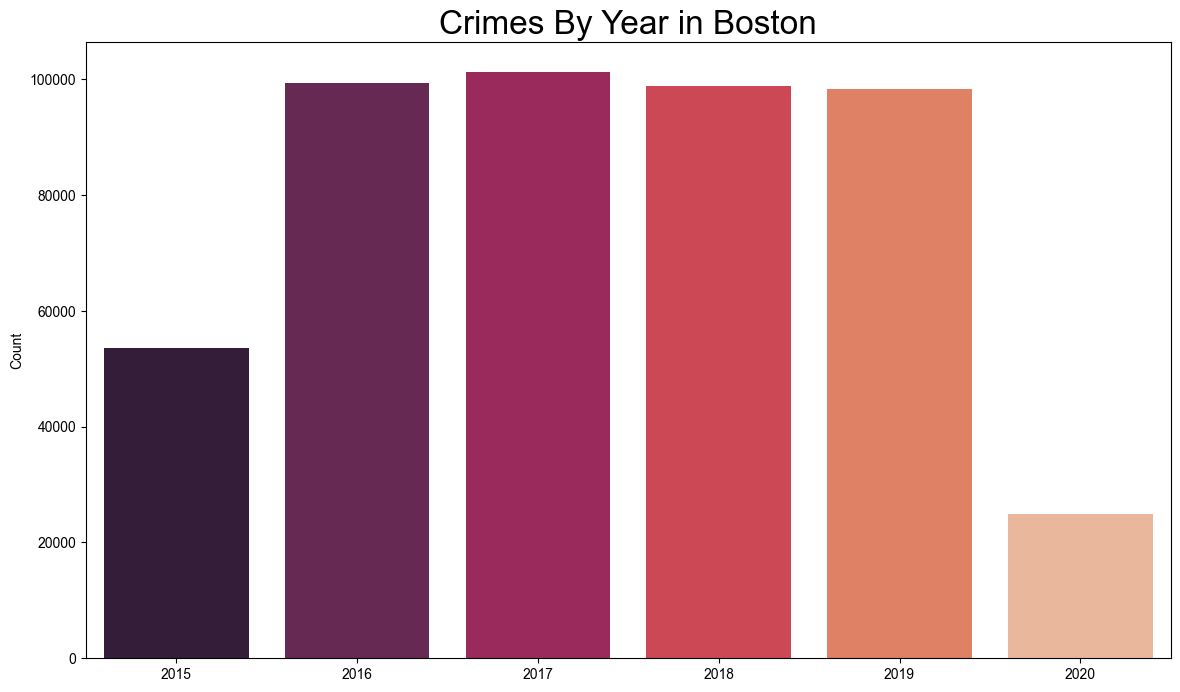

In [9]:
#Crimes By Year Histogram
years=[2015,2016,2017,2018,2019,2020]
crimes_per_year = pd.DataFrame({'Count': spreadsheet['YEAR'].value_counts().sort_index().values}, index = years)
plt.figure(figsize = (14, 8))
sns.barplot(x = crimes_per_year.index, y = 'Count', data = crimes_per_year, palette = 'rocket')
sns.set(font_scale=1.25)
plt.title('Crimes By Year in Boston', fontsize = 24)

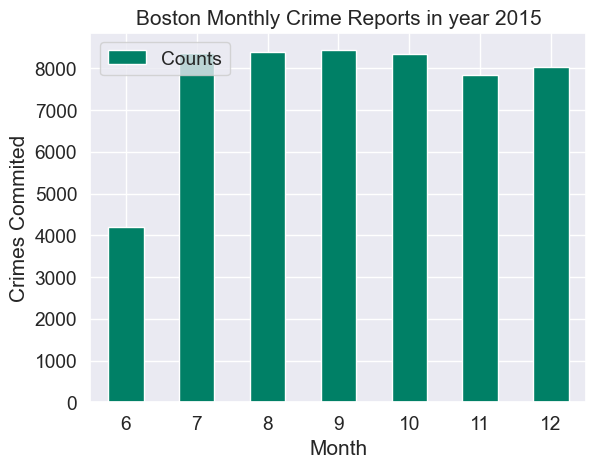

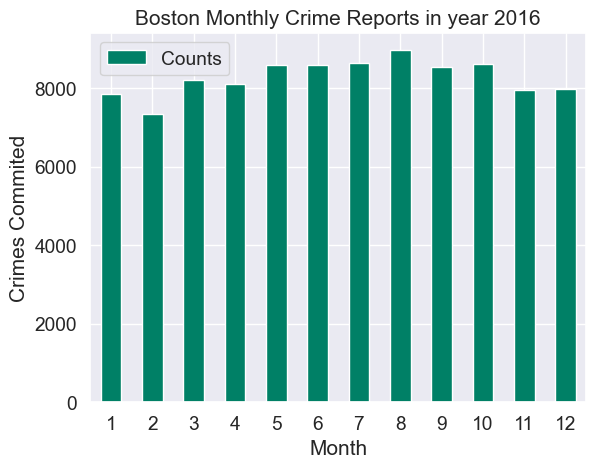

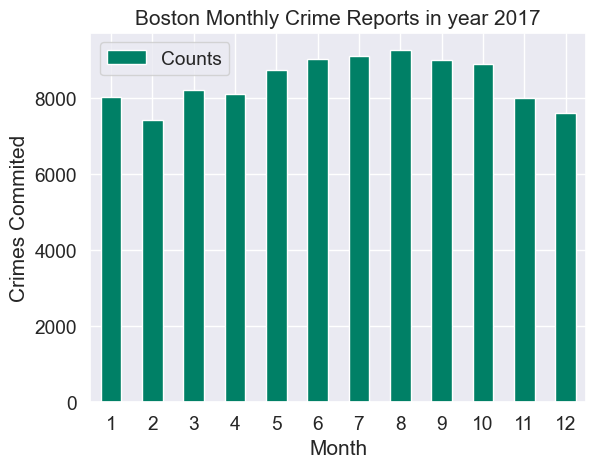

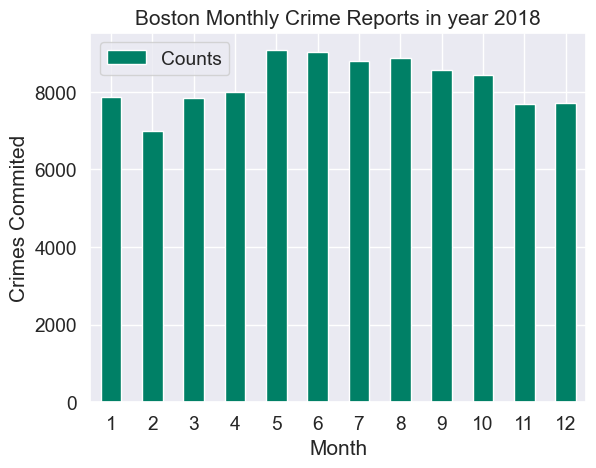

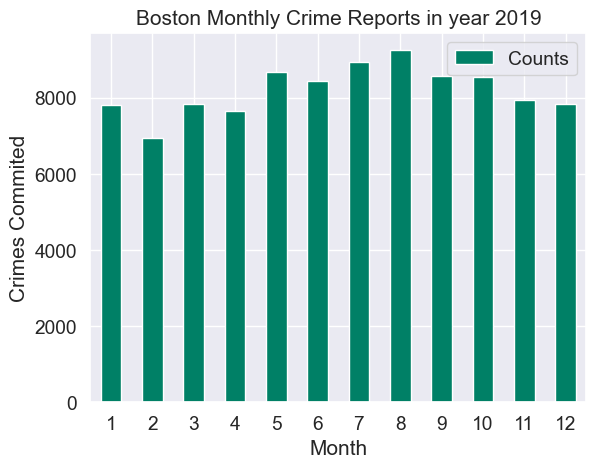

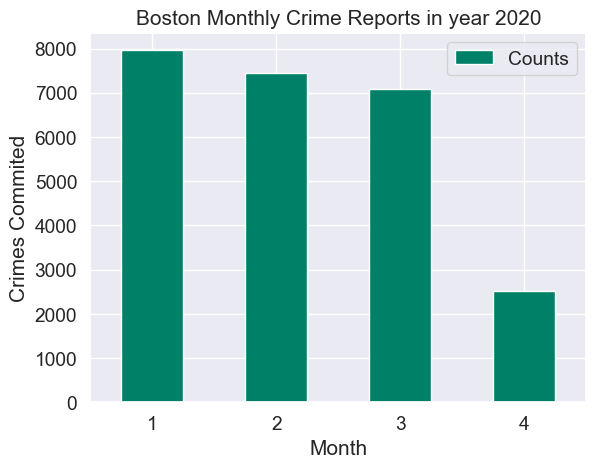

In [10]:
# Observation: significantly lower recorded info for 2015 and 2020
# Yearly and Monthly Graph Breakdown
for x in years:
    curr = spreadsheet[spreadsheet.YEAR == x]    
    curr=curr.groupby(["YEAR", "MONTH"]).size().reset_index(name="Counts")
    graph = curr.plot.bar(x='MONTH', y='Counts',colormap='summer', rot=0)
    plt.title('Boston Monthly Crime Reports in year '+str(x))
    plt.ylabel("Crimes Commited")
    plt.xlabel("Month")

# Indicates that 2015 and 2020 both don't have complete datasets 

Text(0.5, 1.0, 'Monthly Crimes in Boston')

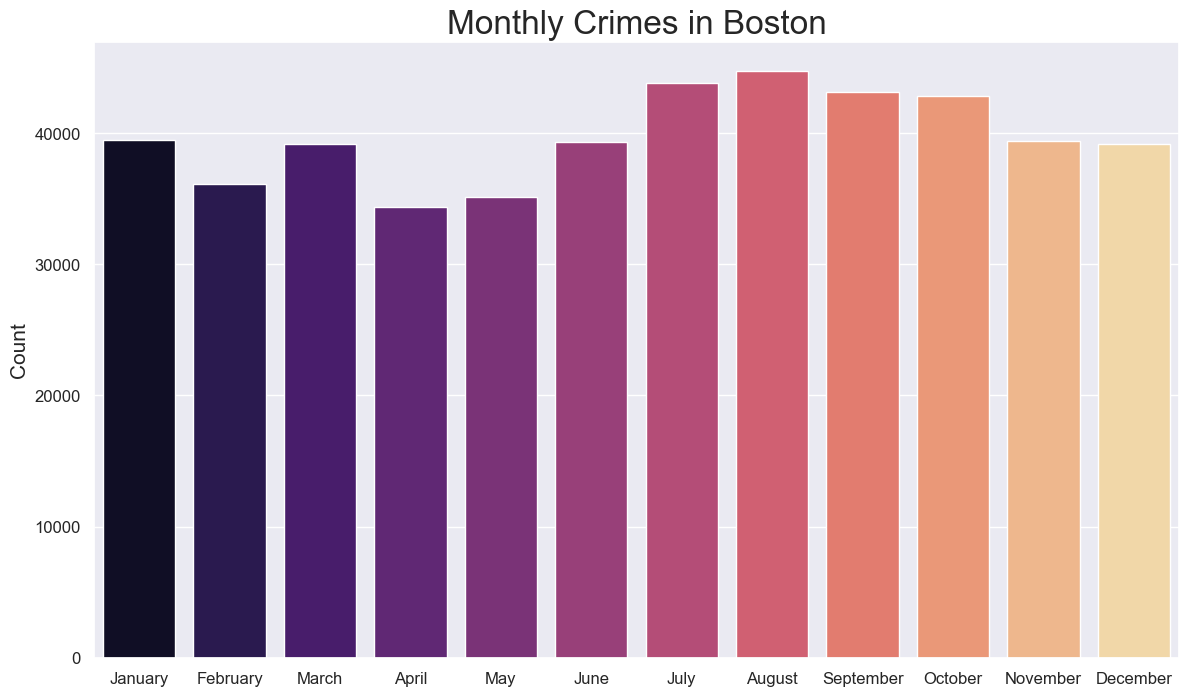

In [11]:
# Overall Monthly Crimes in Boston
# Keep in mind that 1-5 are unrecorded and 6 is paritally recorded for 2015, 5-12 are unrecorded 
#    and 4 is partially recorded for 2020. Because each month is missing roughly a year of data, the numbers won't
#    be incredibly skewed, but worth considering
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
crimes_per_month = pd.DataFrame({'Count': spreadsheet['MONTH'].value_counts().sort_index().values}, index = months)
plt.figure(figsize = (14, 8))
sns.barplot(x = crimes_per_month.index, y = 'Count', data = crimes_per_month, palette = 'magma')
plt.tick_params(labelsize = 12)
plt.title('Monthly Crimes in Boston', fontsize = 24)

Text(0.5, 0, 'District Code')

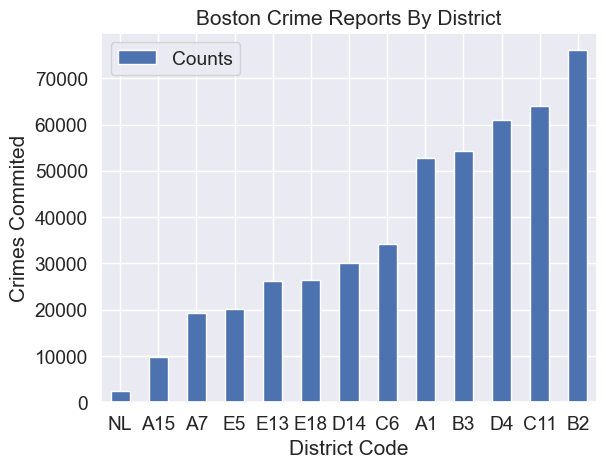

In [12]:
#District Histogram
# Note:
#few cases of external where long/lat is given
    # of these, some are in the city (under 10), however vast majority are outside city lines
    # for example, found crime at 42.328662, -71.085634 which wasn't recorded in a certain district
    # analysis will treat these as unrecorded data 
# 67 case of external wehre location is unrecorded -> will group external into unrecorded location

district=spreadsheet.copy()
Unrecorded = district["DISTRICT"].isna().sum()
district['Counts'] = district.groupby(['DISTRICT'])['DISTRICT'].transform('count')
district=district[['DISTRICT', 'Counts']].drop_duplicates(subset=['DISTRICT'])
Unrecorded+= district.iloc[13]['Counts'] #add 'external' into Not Listed set
district["Counts"].fillna(Unrecorded, inplace = True)
district=district.drop(labels=426891) #remove external edge case
district["DISTRICT"].fillna('NL', inplace = True)
district=district.sort_values(by=['Counts'])
district.plot.bar(x='DISTRICT', y='Counts', rot=0)
plt.title('Boston Crime Reports By District')
plt.ylabel("Crimes Commited")
plt.xlabel("District Code")

In [13]:
# Bubble Map where size of bubble corresponds to amount of crimes committed
m = folium.Map(location=[42.3601,-71.0589], tiles="OpenStreetMap", zoom_start=12)

df = district.set_index('DISTRICT')
data = pd.DataFrame({
   'lon':[-71.0594, -71.0649, -71.0616, -71.0706, -71.1321, -71.0254, -71.1600, -71.091375,-71.1203,-71.0855,-71.049495, -71.1213],
   'lat':[42.3555, 42.2995, 42.3787, 42.3407, 42.3529, 42.3800, 42.2782, 42.315198, 42.3098,42.2700,42.333431, 42.2533],
   'name':['A1', 'C11', 'A15', 'D4', 'D14', 'A7', 'E5', 'B2', 'E13', 'B3', 'C6', 'E18'],
   'value':[df.at['A1', 'Counts'], df.at['C11', 'Counts'], df.at['A15', 'Counts'], df.at['D4', 'Counts'], df.at['D14', 'Counts'], 
            df.at['A7', 'Counts'], df.at['E5', 'Counts'], df.at['B2', 'Counts'],df.at['E13', 'Counts'],df.at['B3', 'Counts']
            ,df.at['C6', 'Counts'],df.at['E18', 'Counts']]
}, dtype=str)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['name'],
      radius=float(data.iloc[i]['value'])*.025,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

m


In [14]:
#Violent Crime Analysis
    #some cases in OFFENSE_CODE_GROUP where crimes is non-negative- Missing Person Located, Property Found
    # Note: no cases of sexual assault or rape
#Methodology
#In the FBI’s Uniform Crime Reporting (UCR) Program, violent crime is composed of four offenses: 
#murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault. 
#Violent crimes are defined in the UCR Program as those offenses which involve force or threat of force.

#Robbery, Defined as:
#Larceny From Motor Vehicle
#Larceny 
#Auto Theft
#Residential Burglary
#Other Burglary
#Commercial Burglary
#Robbery
#Burglary - No Property Taken
#HOME INVASION


#Assault, Defined As:
#Simple Assault
#Aggravated Assault 


#Murder, Defined As:
#Homicide
#Manslaughter
murder=spreadsheet.copy()
assault=spreadsheet.copy()
robbery=spreadsheet.copy()
nonviolent=spreadsheet.copy()

murder = murder[murder['OFFENSE_CODE_GROUP'].isin(['Homicide','Manslaughter'])]
assault =assault[assault['OFFENSE_CODE_GROUP'].isin(['Aggravated Assault','Simple Assault'])]
robbery =robbery[robbery['OFFENSE_CODE_GROUP'].isin(['Larceny From Motor Vehicle','Larceny','Auto Theft',
                                                             'Residential Burglary','Other Burglary',
                                                             'Commercial Burglary','Robbery','Burglary - No Property Taken',
                                                             'HOME INVASION'])]
nonviolent=nonviolent[nonviolent['OFFENSE_CODE_GROUP'].isin(['Larceny From Motor Vehicle','Larceny','Auto Theft',
                                        'Residential Burglary','Other Burglary',
                                        'Commercial Burglary','Robbery','Burglary - No Property Taken',
                                        'HOME INVASION','Homicide','Manslaughter',
                                        'Aggravated Assault','Simple Assault'])==False]

murder['Violent Crime Type']='Murder'
robbery['Violent Crime Type']='Robbery'
assault['Violent Crime Type']='Assault'

frames = [murder, robbery, assault]

vc=pd.concat(frames)

vc


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,Violent Crime Type
4663,I152056746,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",E13,639,NaN,7/2/2015 16:30,2015,7,Thursday,16,Part One,ROBINWOOD AVE,42.316240,-71.112670,"(42.31624019, -71.11267011)",Murder
4743,I152054787,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",B2,281,Y,7/2/2015 23:08,2015,7,Thursday,23,Part One,GREENVILLE ST,42.326968,-71.080519,"(42.32696802, -71.08051941)",Murder
4744,I152054787,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",B2,281,Y,7/2/2015 23:08,2015,7,Thursday,23,Part One,GREENVILLE ST,42.326968,-71.080519,"(42.32696802, -71.08051941)",Murder
5268,I152055311,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",B2,322,Y,7/4/2015 22:47,2015,7,Saturday,22,Part One,GLENBURNE ST,42.315122,-71.082520,"(42.31512218, -71.08252020)",Murder
5269,I152055311,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",B2,322,Y,7/4/2015 22:47,2015,7,Saturday,22,Part One,GLENBURNE ST,42.315122,-71.082520,"(42.31512218, -71.08252020)",Murder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,I192078603,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A7,23,NaN,9/29/2019 1:30,2019,9,Sunday,1,Part Two,BENNINGTON ST,42.375470,-71.037302,"(42.37546983, -71.03730221)",Assault
426809,I192078608,801,Simple Assault,ASSAULT - SIMPLE,E18,501,NaN,9/29/2019 1:35,2019,9,Sunday,1,Part Two,CANTERBURY ST,42.278688,-71.117344,"(42.27868789, -71.11734430)",Assault
426819,I192078613,423,Aggravated Assault,ASSAULT - AGGRAVATED,A7,17,NaN,9/29/2019 2:30,2019,9,Sunday,2,Part One,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)",Assault
426820,I192078613,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A7,17,NaN,9/29/2019 2:30,2019,9,Sunday,2,Part Two,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)",Assault


Text(0.5, 1.0, 'Violent Crimes by Type, Boston')

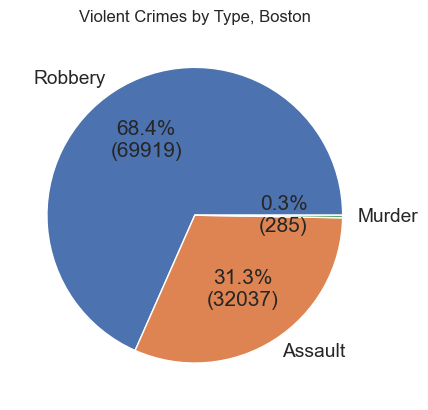

In [15]:
# Percentage Breakdown within Violent Crimes 
# compares types of violent crimes in Boston by Percentage

# Function to get percentages for graph
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

vc_counts=vc['Violent Crime Type'].value_counts()
plt.pie(vc_counts,labels = vc_counts.index, autopct=autopct_format(vc_counts))
plt.title('Violent Crimes by Type, Boston', fontsize = 12)

In [16]:
# Violent Crime Mapping
# Bubble map for Boston districts based on violent crime

vcmap = folium.Map(location=[42.3601,-71.0589], tiles="OpenStreetMap", zoom_start=12)

vcdistrict=vc.copy()
vcdistrict['Counts'] = vcdistrict.groupby(['DISTRICT'])['DISTRICT'].transform('count')
vcdistrict=vcdistrict[['DISTRICT', 'Counts']].drop_duplicates(subset=['DISTRICT'])

df = vcdistrict.set_index('DISTRICT')
data = pd.DataFrame({
   'lon':[-71.0594, -71.0649, -71.0616, -71.0706, -71.1321, -71.0254, -71.1600, -71.091375,-71.1203,-71.0855,-71.049495, -71.1213],
   'lat':[42.3555, 42.2995, 42.3787, 42.3407, 42.3529, 42.3800, 42.2782, 42.315198, 42.3098,42.2700,42.333431, 42.2533],
   'name':['A1', 'C11', 'A15', 'D4', 'D14', 'A7', 'E5', 'B2', 'E13', 'B3', 'C6', 'E18'],
   'value':[df.at['A1', 'Counts'], df.at['C11', 'Counts'], df.at['A15', 'Counts'], df.at['D4', 'Counts'], df.at['D14', 'Counts'], 
            df.at['A7', 'Counts'], df.at['E5', 'Counts'], df.at['B2', 'Counts'],df.at['E13', 'Counts'],df.at['B3', 'Counts']
            ,df.at['C6', 'Counts'],df.at['E18', 'Counts']]
}, dtype=str)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['name'],
      radius=float(data.iloc[i]['value'])*.09, #Note, size of circle increased from previous bubble map with goal of showing proportion
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(vcmap)

vcmap


Text(0.5, 1.0, 'Non-Violent vs. Violent Crimes, Boston')

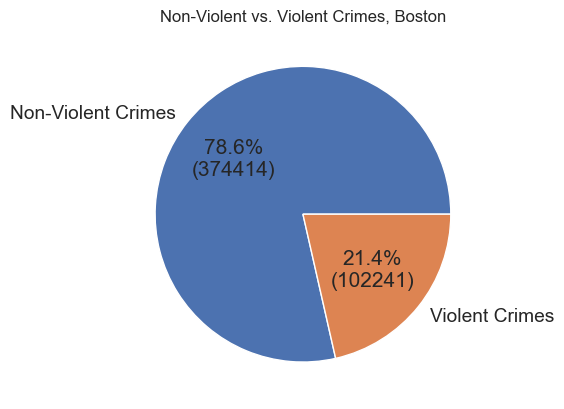

In [17]:
#Comparing Violent To Non-Violent Crimes Percentages
frames = [vc,nonviolent]
violentcrimecomp=pd.concat(frames)
violentcrimecomp=violentcrimecomp.where(~violentcrimecomp.notna(), 'Violent Crimes')
violentcrimecomp['Violent Crime Type'].fillna('Non-Violent Crimes', inplace = True)

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format
comp_counts=violentcrimecomp['Violent Crime Type'].value_counts(dropna=False)
plt.pie(comp_counts,labels = comp_counts.index, autopct=autopct_format(comp_counts))
plt.title('Non-Violent vs. Violent Crimes, Boston', fontsize = 12)

Text(0.5, 1.0, 'Boston Crimes per Hour')

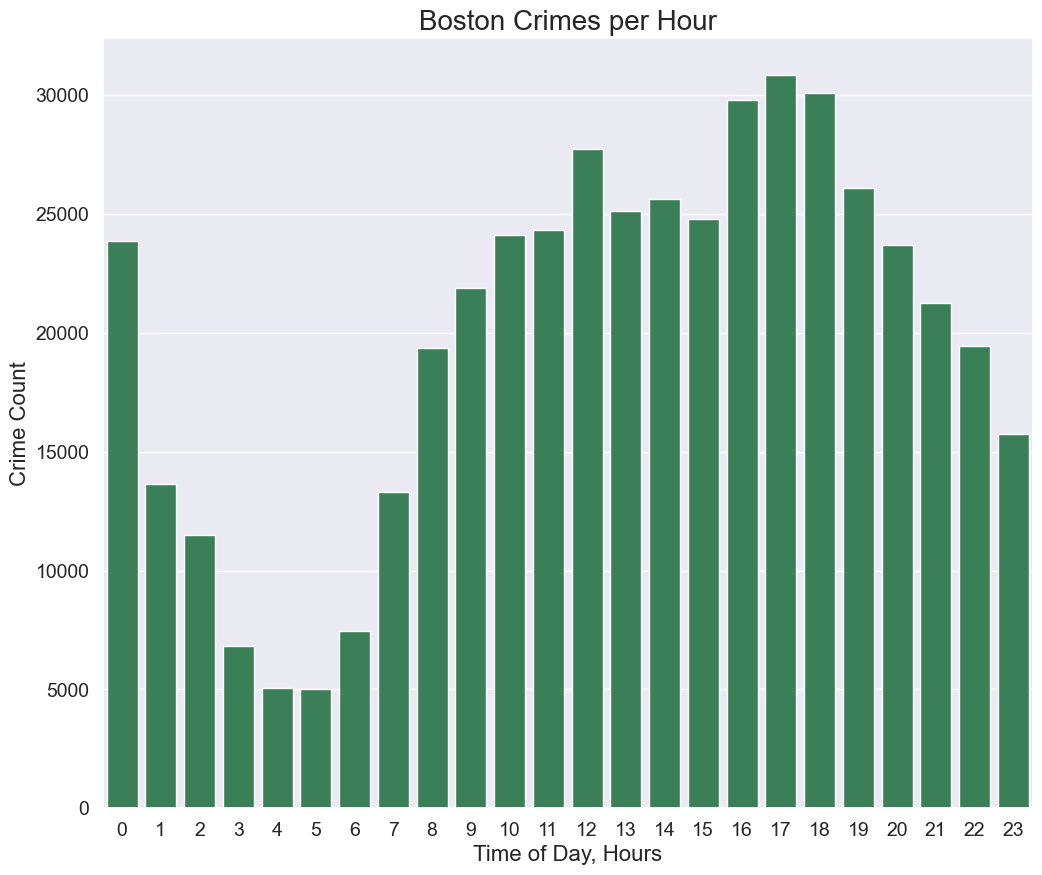

In [18]:
# Boston crimes per hour histogram
per_hour = pd.DataFrame({'Count': spreadsheet['HOUR'].value_counts().sort_index()})
plt.figure(figsize = (12,10))
sns.barplot(x = per_hour.index, y = per_hour['Count'], data = per_hour, color = 'seagreen')
plt.ylabel("Crime Count",fontsize=16)
plt.xlabel("Time of Day, Hours",fontsize=16)
plt.tick_params(labelsize = 14)
plt.title('Boston Crimes per Hour', fontsize = 20)


In [33]:
# importing police districts 
districts = pd.read_csv('/Users/bayardwalsh/Desktop/boston district OG.csv', low_memory=False)
districts.rename(columns={'CENTROIDX': 'Long', 'CENTROIDY': 'Lat'}, inplace=True)
districts

,X,Y,ADDRESS,NAME,ZIP,PARCEL_ID,OBJECTID_1,OBJECTID,BPD_ID,ID,FTSQFT,STORY_HT_,Long,Lat
0,774999.899922,2.957181e+06,40 New Sudbury Street,District A-1 Police Station,2114,302626000,1,1,1,42,6882,5.0,-71.0603,42.3618
1,772639.158096,2.949015e+06,650 Harrison Avenue,District D-4 Police,2116,500826000,2,2,2,42,12382,3.0,-71.0707,42.3456
2,763108.700167,2.938134e+06,3345 Washington Street,District E-13 Police Station,2130,1102261000,3,3,3,42,8312,2.0,-71.1046,42.3097
3,766640.400203,2.929034e+06,1165 Blue Hill Avenue,District B-3 Police Station,2126,1404623000,4,4,4,42,9740,1.5,-71.0917,42.2847
4,757882.599874,2.918710e+06,1249 Hyde Park Avenue,District E-18 Police Station,2136,1809107000,5,5,5,42,8585,2.0,-71.1243,42.2565
5,750629.399996,2.952542e+06,301 Washington Street,District D-14 Police Station,2135,2202387000,6,6,6,42,8712,2.0,-71.1505,42.3494
6,766796.600203,2.947049e+06,One Schroeder Plaza,Boston Police Headquarters,2120,902771010,7,7,7,42,194000,4.0,-71.0908,42.3341
7,780842.499992,2.960584e+06,69 Paris Street,District A-7 Police Station,2128,105699000,8,8,8,42,5063,2.0,-71.0386,42.3711
8,777833.900117,2.948947e+06,101 West Broadway,District C-6 Police Station,2127,601606000,9,9,9,42,8528,2.0,-71.0500,42.3392
9,768627.000204,2.944918e+06,2400 Washington St,District B-2 Police Station,2119,1201180000,10,10,10,42,10809,3.0,-71.0841,42.3283


In [34]:
#Heat Map for Overall Common Crimes, 10,000 samples 
dist_long_lat = districts.loc[:, ['Lat', 'Long']].dropna()

m=folium.Map(location = [42.320,-71.05],
                  zoom_start = 11,
                  min_zoom = 11
)

for index, row in dist_long_lat.iterrows():
    folium.Marker([row['Lat'], row['Long']]).add_to(m)

m

In [72]:
data_long_lat = spreadsheet.loc[:, ['Lat', 'Long']].dropna()
k=dist_long_lat.shape[0]

# filtering edge cases
data_long_lat = data_long_lat[data_long_lat['Lat'] >= 42]
data_long_lat = data_long_lat[data_long_lat['Long'] <= -71]

y = data_long_lat.values



# Initialize the KMeans object
kmeans = KMeans(n_clusters=k)

# Fit the data to the KMeans model
kmeans.fit(y)

# Get the cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Print the cluster labels and cluster centers
print("Cluster Labels:")
print(labels)
print("\nCluster Centers:")
print(centers)

/Users/bayardwalsh/micromamba/envs/gen/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels:
447336

Cluster Centers:
[[ 42.36000809 -71.06084377]
 [ 42.28173449 -71.0890621 ]
 [ 42.32233884 -71.10121461]
 [ 42.3307852  -71.05106849]
 [ 42.25520013 -71.12286449]
 [ 42.31140363 -71.07478024]
 [ 42.35060384 -71.1433434 ]
 [ 42.33947682 -71.08040836]
 [ 42.28671039 -71.12142764]
 [ 42.29305733 -71.06412401]
 [ 42.37740987 -71.03102282]
 [ 42.27757963 -71.15444703]]


In [85]:
m=folium.Map(location = [42.320,-71.05],
                  zoom_start = 11,
                  min_zoom = 11
)

for i in centers:
    folium.Marker(
    location=[i[0], i[1]],
    icon=folium.Icon(color='blue'),).add_to(m)



og=dist_long_lat.values
for i in og:
    folium.Marker(
    location=[i[0], i[1]],
    icon=folium.Icon(color='red'),).add_to(m)

m

In [86]:
#calculate margin of error for k means vs current, in terms of distance from police stations 
marginoferror = (np.sum(og**2 - centers**2))**(1/2)
print(marginoferror)


1.907592329134778


In [137]:
# use graham_scan algorithim to compute the smallest polygon that contains all data points 


def graham_scan(points):
    # Sort points based on their y-coordinates (and x-coordinates as a tie-breaker)
    sorted_points = sorted(points, key=lambda p: (p[1], p[0]))
    
    # Calculate the cross product of three points
    def cross_product(p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])
    
    # Build the upper hull
    upper_hull = []
    for point in sorted_points:
        while len(upper_hull) >= 2 and cross_product(upper_hull[-2], upper_hull[-1], point) <= 0:
            upper_hull.pop()
        upper_hull.append(point)
    
    # Build the lower hull
    lower_hull = []
    for point in reversed(sorted_points):
        while len(lower_hull) >= 2 and cross_product(lower_hull[-2], lower_hull[-1], point) <= 0:
            lower_hull.pop()
        lower_hull.append(point)
    
    # Combine the upper and lower hulls
    convex_hull = np.array(upper_hull[:-1] + lower_hull[:-1])
    
    return convex_hull

# Example usage
points = y

convex_hull = graham_scan(points)
print(convex_hull)


[[ 42.44984    -71.244055  ]
 [ 42.39504158 -71.01017732]
 [ 42.39146297 -71.00134187]
 [ 42.391462   -71.001341  ]
 [ 42.388502   -71.000377  ]
 [ 42.384239   -71.000039  ]
 [ 42.383549   -71.000044  ]
 [ 42.38266488 -71.00016351]
 [ 42.28458    -71.039739  ]
 [ 42.181845   -71.203312  ]]


In [167]:
# graham scan that contains all data points

# Create a map object
m=folium.Map(location = [42.320,-71.05],
                  zoom_start = 11,
                  min_zoom = 11
)

# Create a list of coordinates for the polygon
polygon_coordinates = convex_hull


#polygon_coordinates=np.append(polygon_coordinates,[[42.2918, -71.0717]], axis=0)

folium.Polygon(locations=[polygon_coordinates], color='blue', fill_color='blue', weight=2,
               line_cap='round', line_join='round',no_clip=True).add_to(m)
m

In [148]:
# use scipy library with convexhull to compute an ordering of points based on distance from center of convex hull

from scipy.spatial import ConvexHull

def order_points_by_distance(points):
    # Compute the convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    # Calculate the center of the convex hull
    center = np.mean(hull_points, axis=0)
    
    # Calculate the distances from each point to the center
    distances = np.linalg.norm(points - center, axis=1)
    
    # Sort the points based on distances
    sorted_points = points[np.argsort(distances)]
    
    return sorted_points

ordered_points = order_points_by_distance(y)
print(ordered_points)




[[ 42.363487   -71.050257  ]
 [ 42.36348797 -71.05025766]
 [ 42.364127   -71.050375  ]
 ...
 [ 42.23346994 -71.13862962]
 [ 42.44984    -71.244055  ]
 [ 42.181845   -71.203312  ]]
(447336, 2)


In [163]:
# abridge points to only contain a certain percent, (ie what is the smallest area with a certain percent of points)
def abridge_by_precent(points,per):
    k=points.size*per//(100*2)
    return points[:k]

byhalf=abridge_by_precent(ordered_points,10)
    

(447336, 2)
(44733, 2)


In [168]:
#recompute polygon with new percentage of points
#50 precent

# Create a map object
m=folium.Map(location = [42.320,-71.05],
                  zoom_start = 11,
                  min_zoom = 11
)

byhalf=abridge_by_precent(ordered_points,50)
polygon_coordinates = graham_scan(byhalf)



folium.Polygon(locations=[polygon_coordinates], color='blue', fill_color='blue', weight=2,
               line_cap='round', line_join='round',no_clip=True).add_to(m)
m

In [171]:
#recompute polygon with new percentage of points
#10 precent

# Create a map object
m=folium.Map(location = [42.320,-71.05],
                  zoom_start = 11,
                  min_zoom = 11
)

tenth=abridge_by_precent(ordered_points,10)
polygon_coordinates = graham_scan(tenth)



folium.Polygon(locations=[polygon_coordinates], color='blue', fill_color='blue', weight=2,
               line_cap='round', line_join='round',no_clip=True).add_to(m)
m